 # Capstone Project 2 - In-Depth Analysis
## Name: Brock Nosbisch

#### Summary:
This is a continuation from the "Capstone Project 2 - Data Wrangling", "Capstone Project 2 - Data Story", and "Capstone Project 2 - EDA" notebooks. The data from the EDA notebook was written to the eda_out.csv file which is read into this notebook.  


# Load Data

In [86]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from datetime import datetime, date

from scipy import stats
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import roc_curve, roc_auc_score, auc, confusion_matrix, classification_report, accuracy_score, SCORERS
from sklearn.metrics.scorer import make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample


# Functions #

def add_value_labels(ax, spacing=5):

    for rect in ax.patches:
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        space = spacing
        va = 'bottom'

        if y_value < 0:
            space *= -1
            # Vertical alignment
            va = 'top'

        label = "{:}".format(y_value)  # Use :.1f if wanting decimals.

        # Create annotation
        ax.annotate(label, (x_value, y_value), xytext=(0, space), textcoords="offset points", ha='center', va=va) 
        
def pearsonr_ci(x,y,alpha=0.05):

    r, p = stats.pearsonr(x,y)
    r_z = np.arctanh(r)
    se = 1/np.sqrt(x.size-3)
    z = stats.norm.ppf(1-alpha/2)
    low_z, high_z = r_z-z*se, r_z+z*se
    low, high = np.tanh((low_z, high_z))
    return r, p, low, high

# Bootstrap Replicates
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

# Test SVM
# Pass X_train, y_train, X_test, y_test, Maximum Iterations you want, C values in a list 
def svm_test(X_train, y_train, X_test, y_test, maxiter=1000, crange=[0.01,0.1,1,10,100]):
    # X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=10)
    model = svm.LinearSVC(C=1, random_state=50)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    #tune parameter C
    # crange = [0.01,0.1,1,10,100,1000]
    for num in crange:
        model = svm.LinearSVC(C=num, max_iter = maxiter)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        print ('C=' + str(num) + ',score={}'.format(accuracy_score(y_test,y_pred)))
        print(confusion_matrix(y_test, y_pred))
        
def print_stats(y_test, y_pred):
        
    savings_for_rescheduling = 100
    cost_of_nonproductive_call = -10
    missed_chance = -10
    
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    print()
    print()
    tp, fp, fn, tn = confusion_matrix(y_test, y_pred).ravel()
    # total_profit = (tp * avg_loan_amount * avg_interest_rate * avg_loan_years) + (fp * avg_loan_amount * avg_interest_rate * avg_loan_years * -1) + (fn * avg_loan_amount * -1)
    total_savings = (tp*0) + (fp*missed_chance) + (fn*cost_of_nonproductive_call) + (tn*savings_for_rescheduling)
    
    print('Total Savings {}'.format(total_savings))
    print()
    print()
    print('Classification Report:')
    print(classification_report(y_test, y_pred))
    print()
    print('Accuracy Score: {}'.format(accuracy_score(y_test, y_pred)))
    
def print_cv_scores(clf, X_test, y_test, scoring_type, n_CV=5, jobs=-1):
    cv_scores = cross_val_score(clf, X_test, y_test, cv=n_CV, scoring=scoring_type, n_jobs=jobs)
    print('CV Scores:')
    print(cv_scores)
    print()
    cv_score_avg = np.mean(cv_scores)
    print('Total Savings: ' + str(cv_score_avg*n_CV))
    print()



# Load Data #

# file_name = 'eda_out.csv' # Service Agreement Level

# df=pd.DataFrame()

# Read in the file with new column names.
# df = pd.read_csv(file_name, header=0)

# df.set_index('SA_ID', inplace=True)

# Change Data Types #
# df = df.astype({'ACCOUNT_ID':'str', 
#                 'PERSON_ID':'str', 
#                 'SA_STATUS_FLAG':'str', 
#                 'PREMISE_ID':'str',
#                 'POSTAL':'str',
#                 'SA_START_YEAR':'str',
#                 'SA_START_YEAR_MONTH':'str',
#                 'SA_END_YEAR':'str',
#                 'SA_END_YEAR_MONTH':'str',
#                 'SA_START_DATE':'datetime64[ns]',
#                 'SA_END_DATE':'datetime64[ns]',
#                 'MOST_RECENT_PAYMENT_DATE':'datetime64[ns]',
#                 'PERSON_MAX_SA_START_DATE':'datetime64[ns]',
#                 'PERSON_MIN_SA_START_DATE':'datetime64[ns]',   
#                 'PERSON_MAX_SA_END_DATE':'datetime64[ns]',
#                 'PERSON_MIN_SA_END_DATE':'datetime64[ns]',
#                 'PREMISE_MAX_SA_START_DATE':'datetime64[ns]',
#                 'PREMISE_MIN_SA_START_DATE':'datetime64[ns]',
#                 'PREMISE_MAX_SA_END_DATE':'datetime64[ns]',
#                 'PREMISE_MIN_SA_END_DATE':'datetime64[ns]',
#                 'PREMISE_PRIOR_STOP_DATE':'datetime64[ns]',
#                 'PERSON_PRIOR_STOP_DATE':'datetime64[ns]',
#                 #'PLEDGE_DATE_2013':'datetime64[ns]',
#                 #'PLEDGE_DATE_2014':'datetime64[ns]',
#                 'PLEDGE_DATE_2015':'datetime64[ns]',
#                 'PLEDGE_DATE_2016':'datetime64[ns]',
#                 'PLEDGE_DATE_2017':'datetime64[ns]',
#                 'PLEDGE_DATE_2018':'datetime64[ns]'#,
#                 #'PLEDGE_DATE_2019':'datetime64[ns]'
#                })


file_name = 'eda_active_out.csv' # Service Agreement Level

df2=pd.DataFrame()

# Read in the file with new column names.
df2 = pd.read_csv(file_name, header=0)

df2.set_index('SA_ID', inplace=True)


# Change Data Types #
df2 = df2.astype({'ACCOUNT_ID':'str', 
                'PERSON_ID':'str', 
                'SA_STATUS_FLAG':'str', 
                'PREMISE_ID':'str',
                'POSTAL':'str',
                'SA_START_YEAR':'str',
                'SA_START_YEAR_MONTH':'str',
                'SA_END_YEAR':'str',
                'SA_END_YEAR_MONTH':'str',
                'SA_START_DATE':'datetime64[ns]',
                'SA_END_DATE':'datetime64[ns]',
                'MOST_RECENT_PAYMENT_DATE':'datetime64[ns]',
                'PERSON_MAX_SA_START_DATE':'datetime64[ns]',
                'PERSON_MIN_SA_START_DATE':'datetime64[ns]',   
                'PERSON_MAX_SA_END_DATE':'datetime64[ns]',
                'PERSON_MIN_SA_END_DATE':'datetime64[ns]',
                'PREMISE_MAX_SA_START_DATE':'datetime64[ns]',
                'PREMISE_MIN_SA_START_DATE':'datetime64[ns]',
                'PREMISE_MAX_SA_END_DATE':'datetime64[ns]',
                'PREMISE_MIN_SA_END_DATE':'datetime64[ns]',
                'PREMISE_PRIOR_STOP_DATE':'datetime64[ns]',
                'PERSON_PRIOR_STOP_DATE':'datetime64[ns]',
                #'PLEDGE_DATE_2013':'datetime64[ns]',
                #'PLEDGE_DATE_2014':'datetime64[ns]',
                'PLEDGE_DATE_2015':'datetime64[ns]',
                'PLEDGE_DATE_2016':'datetime64[ns]',
                'PLEDGE_DATE_2017':'datetime64[ns]',
                'PLEDGE_DATE_2018':'datetime64[ns]'#,
                #'PLEDGE_DATE_2019':'datetime64[ns]'
               })

# Removing columns that may leak data.
del df2['SA_END_DATE']
del df2['SA_END_YEAR']
del df2['SA_END_YEAR_MONTH']
del df2['SA_STATUS_FLAG']
del df2['SA_END_DEGREE_DAY']
del df2['SA_END_AVG_TEMP']
del df2['STOP_2019']
del df2['STOP_7_DAYS_FROM_20190301']
del df2['STOP_14_DAYS_FROM_20190301']

## Train / Test / Split

In [88]:
# Used for train_test_split.
X = df2[['DNP_STARTED_FLAG_NUMBER','DNP_STOPPED_FLAG_NUMBER','INTERNAL_CREDIT_RATING','PERSON_RCVD_18_MTHS_PLEDGE_NUM','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','ARREARS_PAYOFF_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SEASONAL_PRIOR_1_YR_FLAG_NUM','SEASONAL_PRIOR_2_YR_FLAG_NUM','SEASONAL_PRIOR_3_YR_FLAG_NUM','SA_START_AVG_TEMP','START_2013','START_2014','START_2015','START_2016','START_2017','START_2018','START_2019','PLEDGE_DATE_2017_NUM','PLEDGE_DATE_2018_NUM','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301']]
y = df2['STOP_21_DAYS_FROM_20190301']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=50)


# Split the Training and Test Sets for upsampling.
# I am using the same Random Stage so the data will be the same as above BUT to resample, we need X_train_2 to have the 'serious_delinquent' value so that we can balance the data.
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=.4, random_state=50) 

X_train_2['STOP_21_DAYS_FROM_20190301'] = y_train_2


# Continuous Variables w/ Stop Flags
cont_vars = ['INTERNAL_CREDIT_RATING','PAYMENTS_IN_LAST_18_MONTHS','BILLS_IN_LAST_18_MONTHS','PAY_SEGS_IN_LAST_18_MONTHS','BILL_SEGS_IN_LAST_18_MONTHS','ARREARS_CURRENT_AMOUNT','ARREARS_PAYOFF_AMOUNT','TOTAL_CURRENT_AMOUNT','TOTAL_PAYOFF_AMOUNT','LATE_PAYMENT_COUNT','SA_START_AVG_TEMP','USAGE_IN_LAST_18_MONTHS','PREMISE_DAYS_INACTIVE_BEFORE','PERSON_DAYS_INACTIVE_BEFORE','PREMISE_DAYS_ACTIVE_BEFORE','PERSON_DAYS_ACTIVE_BEFORE','ACTIVE_DIFF_FROM_20190301','STOP_21_DAYS_FROM_20190301']


print()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


### Resampling to Upsample

In [89]:
# Resampling to Upsample the Stops.

# Separating Stops and Active SAs who didn't stop
df_stop_21 = X_train_2[X_train_2['STOP_21_DAYS_FROM_20190301'] == 1] 
df_no_stop_21 = X_train_2[X_train_2['STOP_21_DAYS_FROM_20190301'] == 0]

print('Number of 21 Day Stops: {}'.format(np.ma.count(df_stop_21['STOP_21_DAYS_FROM_20190301'])))
print('Number of Active SAs that did not stop: {}'.format(np.ma.count(df_no_stop_21['STOP_21_DAYS_FROM_20190301'])))

resample_count = np.ma.count(df_no_stop_21['STOP_21_DAYS_FROM_20190301']) # Need to resample the defaults - np.ma.count(df_default['serious_delinquent'])

df_stop_21_samples = resample(df_stop_21, replace=True, n_samples=resample_count, random_state=50) # Resampling
print('Number of New Defaults (resampled): {}'.format(np.ma.count(df_stop_21_samples['STOP_21_DAYS_FROM_20190301'])))
print()

df_resampled = pd.concat([df_stop_21_samples, df_no_stop_21]) # combine all data
print('Count of Records after Resampling: {}'.format(np.ma.count(df_resampled['STOP_21_DAYS_FROM_20190301'])))

# Resampled dependent/independent.
X_r = df_resampled.drop(columns = ['STOP_21_DAYS_FROM_20190301']) 
y_r = df_resampled['STOP_21_DAYS_FROM_20190301']


Number of 21 Day Stops: 2046
Number of Active SAs that did not stop: 202673
Number of New Defaults (resampled): 202673

Count of Records after Resampling: 405346


## Custom Scoring Function

In [92]:
def savings_scorer(y_test, y_pred):
    
    cnt00 = 0
    cnt01 = 0
    cnt10 = 0
    cnt11 = 0
    
    savings = 0
    
    savings_for_rescheduling = 100
    cost_of_nonproductive_call = -10
    missed_chance = -10

    for index in range(len(y_test)):
        y = y_test.iloc[index]
        y_p = y_pred[index]

        if y == 0 and y_p == 0: # TP
            savings += 0 # amt * rate * years = profit
            cnt00 += 1
        elif y == 0 and y_p == 1: # FP
            savings += missed_chance # amt * rate * years = profit
            cnt01 += 1
        elif y == 1 and y_p == 0: # FN
            savings += cost_of_nonproductive_call # We are assuming that a False Positive will result in losing the entire loan amount.
            cnt10 += 1
        elif y == 1 and y_p == 1: # TN
            savings += savings_for_rescheduling  # No cost since we identified the Defaulters
            cnt11 += 1
        else:
            raise ValueError("Something went wrong " + str(index))

    return savings

# This is our customer Scorer to use.
savings_scorer = make_scorer(savings_scorer, greater_is_better=True)  # The higher the revenue the better.


## Logistic Regression

### Add description....

In [93]:
n_CV = 10

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[-1410 -1410 -1410 -1290 -1400 -1400 -1410 -1400 -1410 -1400]

Total Savings: -13940.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[135077      0]
 [  1402      1]]


Total Savings -13920


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135077
           1       1.00      0.00      0.00      1403

   micro avg       0.99      0.99      0.99    136480
   macro avg       0.99      0.50      0.50    136480
weighted avg       0.99      0.99      0.98    136480


Accuracy Score: 0.9897274325908558


In [40]:
# GridSearchCV with LogReg
n_CV = 5
#scoring = {'AUC': 'roc_auc', 'ROC AUC SCORE': 'roc_auc_score', 'Balanced Accuracy': 'balanced_accuracy_score'}

logreg = LogisticRegression(solver='liblinear') # Create the classifier

print_cv_scores(logreg, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

penalty = ['l1', 'l2'] # regularization penablty space
# C = np.logspace(0, 4, 10) # regularization hyperparameter space
C = np.logspace(0, 4, 3) # regularization hyperparameter space

param_grid = dict(C=C, penalty=penalty)

# logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold
logreg_cv = GridSearchCV(logreg, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

logreg_cv.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_cv.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[-2810 -2700 -2810 -2810 -2810]

Total Savings: -13940.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[135077      0]
 [  1402      1]]


Total Savings -13920


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135077
           1       1.00      0.00      0.00      1403

   micro avg       0.99      0.99      0.99    136480
   macro avg       0.99      0.50      0.50    136480
weighted avg       0.99      0.99      0.98    136480


Accuracy Score: 0.9897274325908558


## Logistic Regression (Balanced)
### Add description....


In [94]:
# Logistic Regression (balanced)

logreg_bal = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg_bal, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

logreg_bal.fit(X_train, y_train) # Fit the classifier to the training data

y_pred = logreg_bal.predict(X_test) # Predict the labels of the test set

print_stats(y_test, y_pred)


CV Scores:
[-18220 -15940 -16560 -18510 -18270 -17790 -18150 -17880 -17420 -16610]

Total Savings: -175350.0



C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[103473  31604]
 [   436    967]]


Total Savings -223700


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.77      0.87    135077
           1       0.03      0.69      0.06      1403

   micro avg       0.77      0.77      0.77    136480
   macro avg       0.51      0.73      0.46    136480
weighted avg       0.99      0.77      0.86    136480


Accuracy Score: 0.765240328253224


In [96]:
# Cross Validation w/ Balance
n_CV = 10

logreg3 = LogisticRegression(solver='liblinear', penalty='l2', class_weight='balanced', C=1) # Create the classifier

print_cv_scores(logreg3, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 


CV Scores:
[-18220 -15940 -16560 -18510 -18270 -17790 -18150 -17880 -17420 -16610]

Total Savings: -175350.0



### ROC Curve of Balanced Logistic Regression

ROC AUC Score: 0.7824345387626669



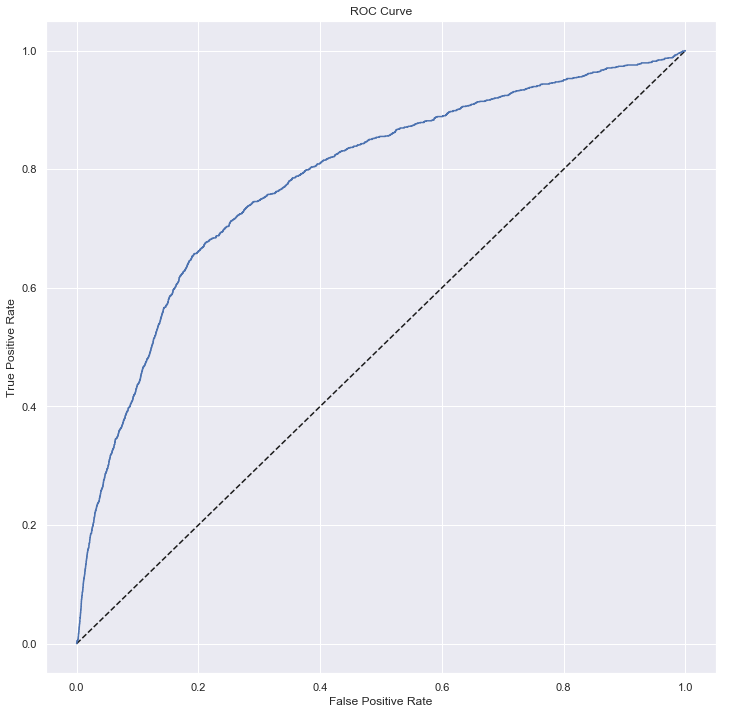

In [98]:
# ROC Curve
y_pred_prob = logreg_bal.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


### Metrics by Subgroups for Logistic Regression (Balanced)

Since this is the best model by Profit, I am testing to see how our Predictions differ by Age and other subgroups.

In [99]:
X_test2 = pd.DataFrame(X_test)
y_test2 = pd.DataFrame(y_test)
y_test2['pred'] = y_pred
y_test2[:][y_test2['pred']==1]

# Merging the X_test2 and y_test2 together.
df3 = pd.concat([X_test2, y_test2.reindex(X_test2.index)], axis=1) 


This graph is showing the Count % of Total Population by Age, Actual Default % by Age, and Predicted Default % by Age.
<br><br>
The model is predicting a good portion of the younger ages to default so it appears the best single model is biased against younger people.  For instance, if you are in your mid-20's, you have over a 35% chance of being predicted as a defaulter. 
<br><br>
To maximize profits, predicting a portion of people to Default when they would have actually paid leads to more profit.  Using our default numbers, it takes 12.5 non-defaulters to make up the losses from 1 defaulter.

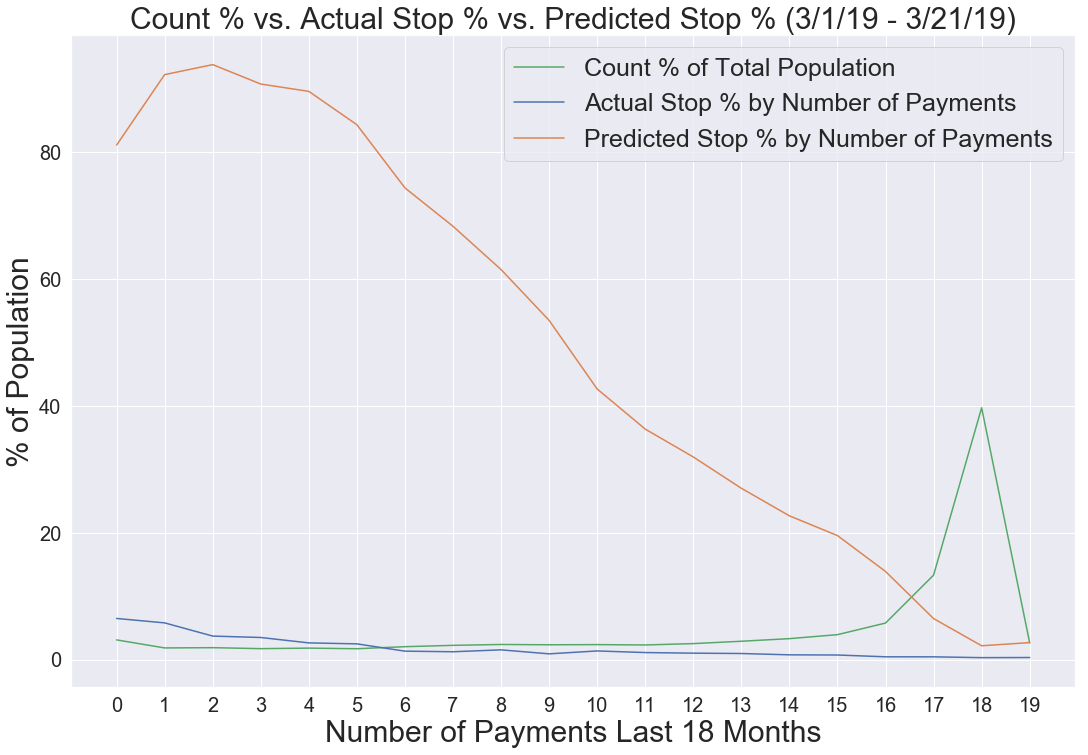

In [100]:

plt.figure(figsize=(18,12))
data = df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20]))
y1 = (data/data.sum())*100
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['STOP_21_DAYS_FROM_20190301'] == 1)& (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y2 = (data2/data)*100

data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][((df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20))].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
y3 = (data3/data)*100
plt.xlabel('Number of Payments Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('Count % vs. Actual Stop % vs. Predicted Stop % (3/1/19 - 3/21/19)', fontsize=30)

plt.plot(x1, y1, color='g', label='Count % of Total Population')
plt.plot(x1, y2, label='Actual Stop % by Number of Payments')
plt.plot(x1, y3, label='Predicted Stop % by Number of Payments')
plt.xticks(np.arange(0,20,1),fontsize=20)
plt.yticks( fontsize=20)
plt.legend(loc=1, prop={'size': 25})

plt.show()

### Add description....

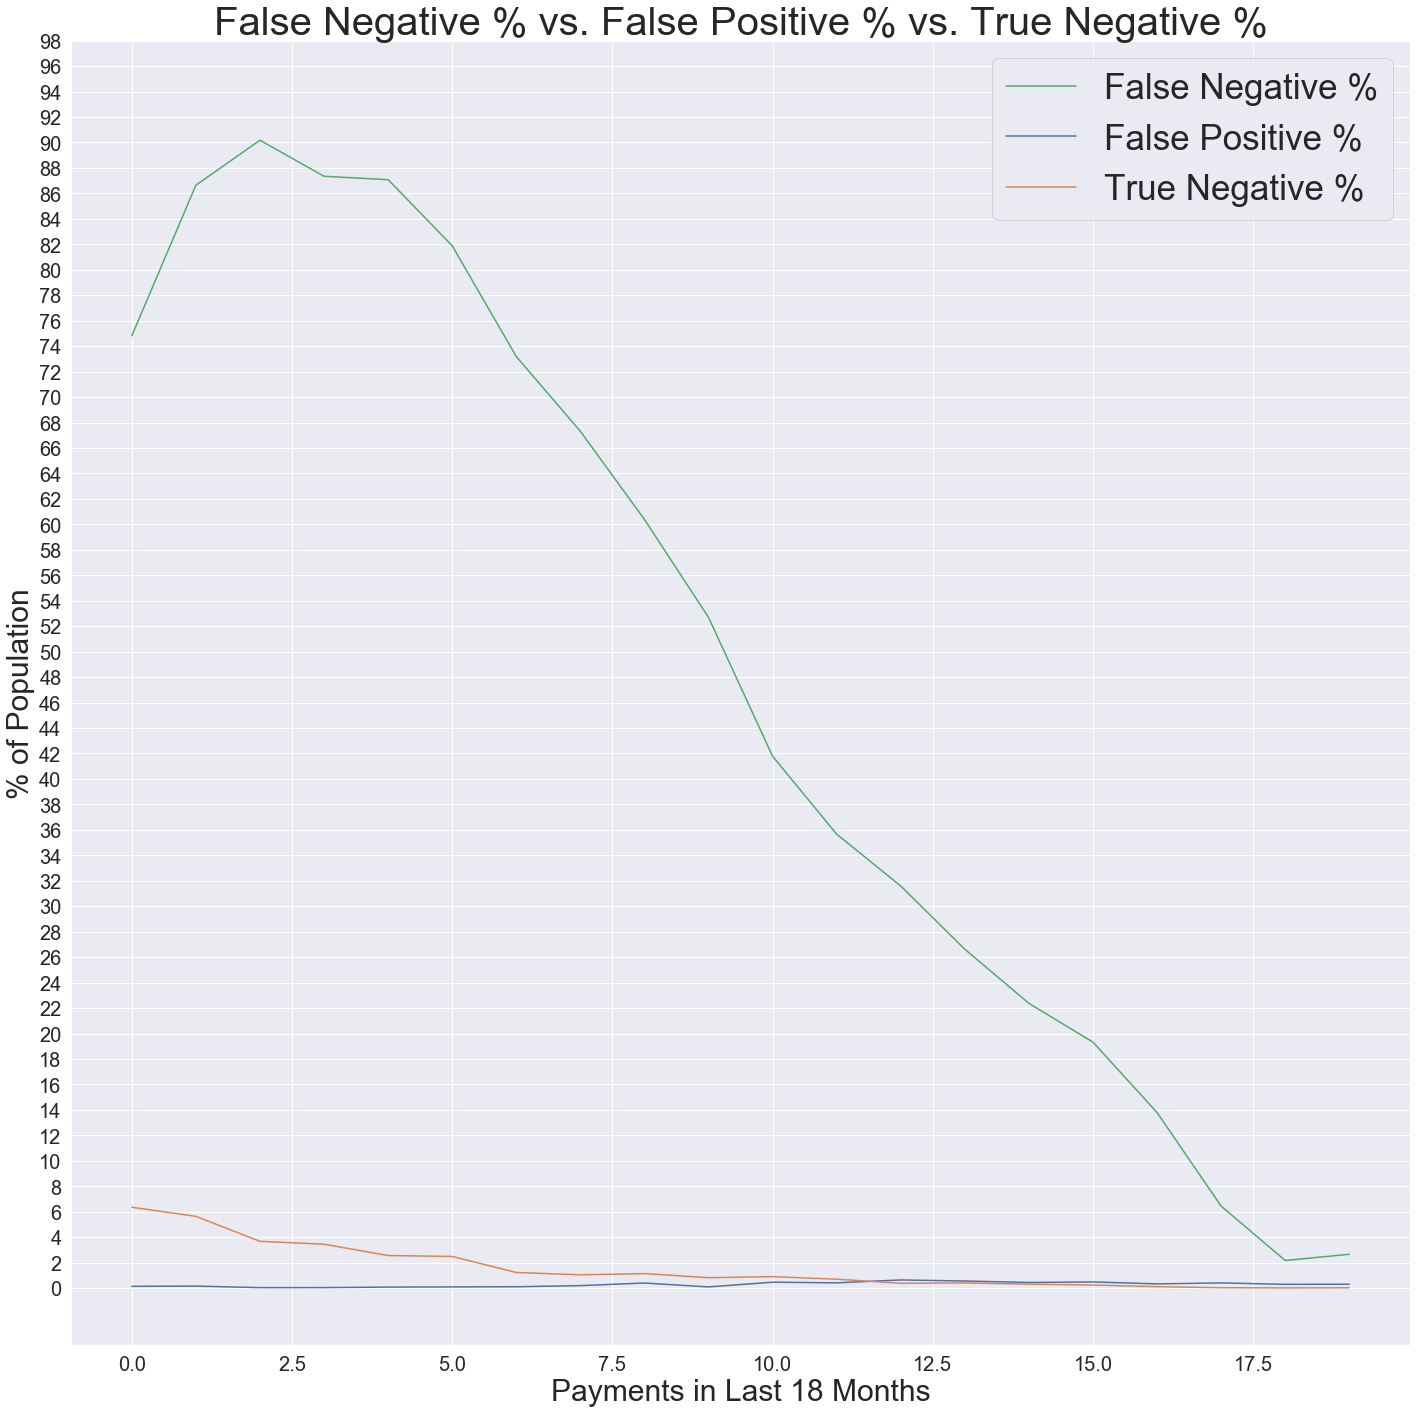

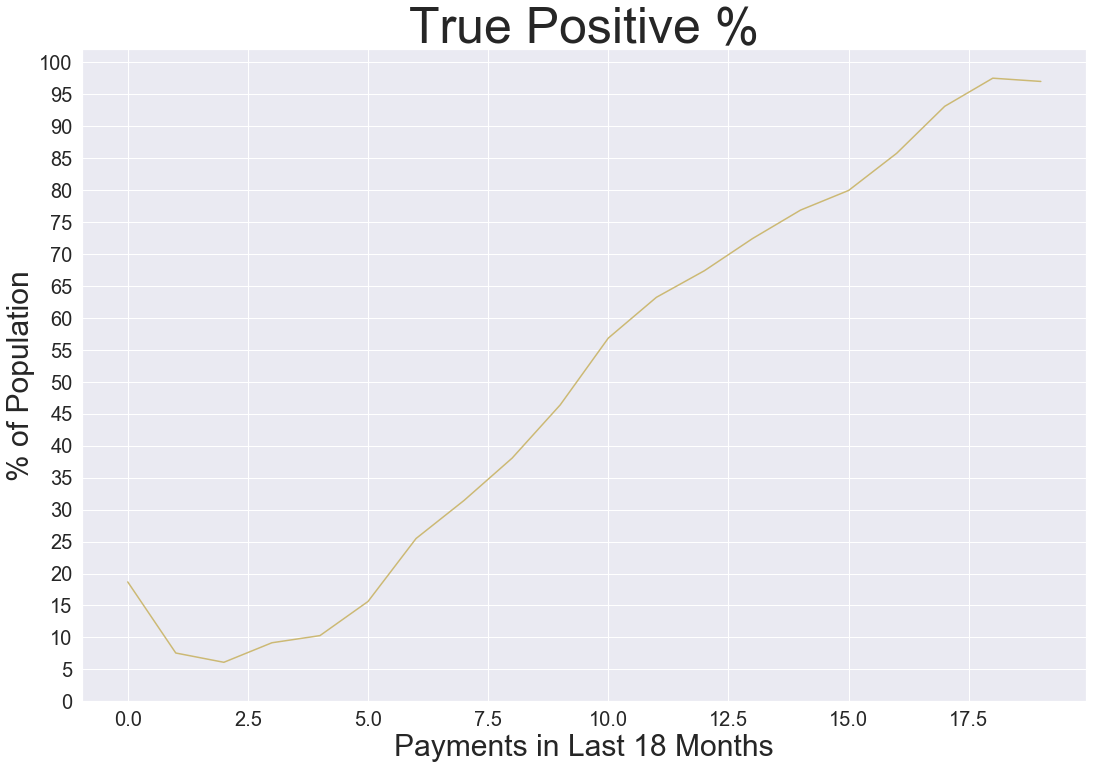

In [104]:

plt.figure(figsize=(24,24))

# False Negative
data1 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x1 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y1 = (data1/data)*100
y1 = y1.dropna()

# False Positive
data2 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x2 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y2 = (data2/data)*100
y2 = y2.dropna()

# True Negative
data3 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x3 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 1) & (df3['pred'] == 1) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y3 = (data3/data)*100
y3 = y3.dropna()

# True Positive
data4 = df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)].groupby(df3['PAYMENTS_IN_LAST_18_MONTHS']).count()
x4 = list(np.unique(df3['PAYMENTS_IN_LAST_18_MONTHS'][(df3['STOP_21_DAYS_FROM_20190301'] == 0) & (df3['pred'] == 0) & (df3['PAYMENTS_IN_LAST_18_MONTHS'] < 20)]))
y4 = (data4/data)*100
y4 = y4.dropna()

plt.xlabel('Payments in Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('False Negative % vs. False Positive % vs. True Negative %', fontsize=40)

plt.plot(x1, y1, color='g', label='False Negative %')
plt.plot(x2, y2, label='False Positive %')
plt.plot(x3, y3, label='True Negative %')
# plt.plot(x4, y4, color='y', label='True Positive %')
plt.xticks(fontsize=20)
plt.yticks(np.arange(0,100,2), fontsize=20)
plt.legend(loc=1, prop={'size': 35})

plt.show()


plt.figure(figsize=(18,12))

plt.xlabel('Payments in Last 18 Months', fontsize=30)
plt.ylabel('% of Population', fontsize=30)
plt.title('True Positive %', fontsize=50)

plt.plot(x4, y4, color='y', label='True Positive %')
plt.xticks(fontsize=20)
plt.yticks(np.arange(0,105,5), fontsize=20)
#plt.legend(loc=1, prop={'size': 35})
plt.show()



## k-NN


### Add description....

In [72]:
n_CV = 5

param_grid = {'n_neighbors': np.arange(1,12)}

knn = KNeighborsClassifier()

print_cv_scores(knn, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn_cv = GridSearchCV(knn, param_grid, cv=n_CV, scoring=savings_scorer, n_jobs=-1) # 5 fold

knn_cv.fit(X_train, y_train)

print('k-NN Best Params: {}'.format(knn_cv.best_params_))
print('k-NN Best Score: {}'.format(knn_cv.best_score_))

knn_neighbors = knn_cv.best_params_


CV Scores:
[-1560 -2170 -2250 -2120 -1620]

Total Savings: -9720.0

k-NN Best Params: {'n_neighbors': 1}
k-NN Best Score: -1585.9954376486794


In [74]:
knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'], weights='uniform')

print_cv_scores(knn, X_test, y_test, savings_scorer, n_CV, -1) # Print cross_val_score using custom scoring 

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

print('Prediction: {}'.format(y_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))

print_stats(y_test, y_pred)

CV Scores:
[  110 -1120 -1820 -1800 -1560]

Total Savings: -6190.0

Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9838730949589684
Confusion Matrix:
[[134111    966]
 [  1235    168]]


Total Savings -5210


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.15      0.12      0.13      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.57      0.56      0.56    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9838730949589684


#### Upsampling
##### Add description....

In [75]:

knn = KNeighborsClassifier(n_neighbors=knn_neighbors['n_neighbors'])

knn.fit(X_r, y_r)

##################################################

# Now running on the original dataset to see what our output is.
y_r_pred = knn.predict(X_test)  # Use the actual dataset to test

print('Prediction: {}'.format(y_r_pred))
print('k-NN Score: {}'.format(knn.score(X_test, y_test)))
print()

# Running the below doesn't really tell us much because the prediction was run on the balanced dataset.

print_stats(y_test, y_r_pred)


Prediction: [0 0 0 ... 0 0 0]
k-NN Score: 0.9838730949589684

Confusion Matrix:
[[134111    966]
 [  1235    168]]


Total Savings -5210


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    135077
           1       0.15      0.12      0.13      1403

   micro avg       0.98      0.98      0.98    136480
   macro avg       0.57      0.56      0.56    136480
weighted avg       0.98      0.98      0.98    136480


Accuracy Score: 0.9838730949589684


ROC Curve results in an AUC Score of 59.7%

ROC AUC Score: 0.5562959652099069



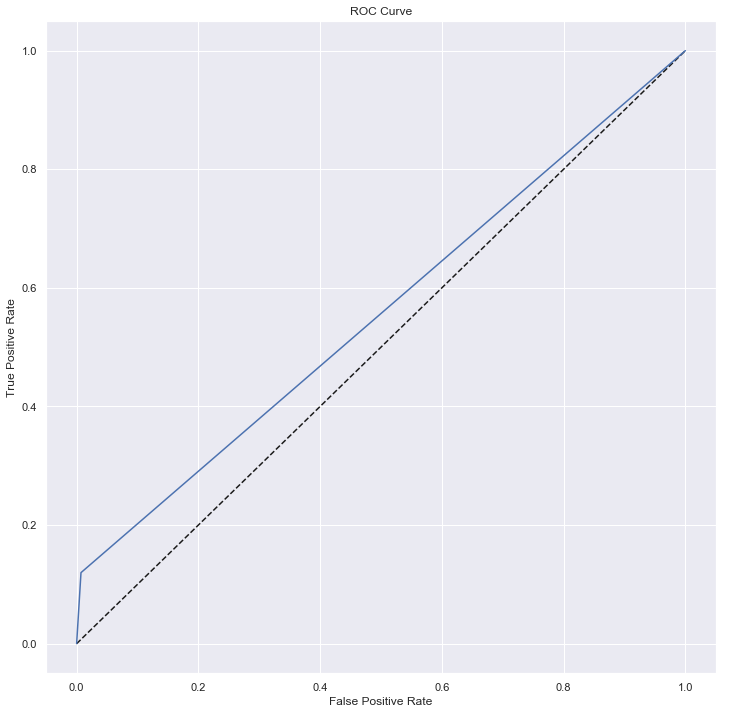

In [76]:
# ROC Curve
y_r_pred_prob = knn.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## Random Forests

### Add description....

In [106]:
# Feature Importance

features = X_train.keys() # Store Feature Names

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, n_jobs=-1) # 1000 Trees
clf.fit(X_train, y_train)

for feature in zip(features, clf.feature_importances_): # Print each feature with gini score.
    print(feature)

('DNP_STARTED_FLAG_NUMBER', 0.008353750411604579)
('DNP_STOPPED_FLAG_NUMBER', 0.013069770411444102)
('INTERNAL_CREDIT_RATING', 0.06309150426169002)
('PERSON_RCVD_18_MTHS_PLEDGE_NUM', 0.004469251149808017)
('PAYMENTS_IN_LAST_18_MONTHS', 0.053550632907696426)
('BILLS_IN_LAST_18_MONTHS', 0.03090183409160993)
('ARREARS_PAYOFF_AMOUNT', 0.1287506187730896)
('TOTAL_PAYOFF_AMOUNT', 0.13047036248825875)
('LATE_PAYMENT_COUNT', 0.027881207238950552)
('SEASONAL_PRIOR_1_YR_FLAG_NUM', 0.0061433088933354465)
('SEASONAL_PRIOR_2_YR_FLAG_NUM', 0.006508984904240155)
('SEASONAL_PRIOR_3_YR_FLAG_NUM', 0.007153846363725086)
('SA_START_AVG_TEMP', 0.07204069245608137)
('START_2013', 0.0014568167062152613)
('START_2014', 0.0016171796310867417)
('START_2015', 0.0020015689880447276)
('START_2016', 0.002359280237664725)
('START_2017', 0.0024612559926029246)
('START_2018', 0.003532684555733578)
('START_2019', 0.0025006919589594455)
('PLEDGE_DATE_2017_NUM', 0.001292091993784548)
('PLEDGE_DATE_2018_NUM', 0.0011555993

### Add description....

In [109]:
# Using the actual data

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, max_features=5, n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)
# print(clf.get_params())


Confusion Matrix:
[[135053     24]
 [  1386     17]]


Total Savings -12400


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135077
           1       0.41      0.01      0.02      1403

   micro avg       0.99      0.99      0.99    136480
   macro avg       0.70      0.51      0.51    136480
weighted avg       0.98      0.99      0.98    136480


Accuracy Score: 0.989668815943728


In [111]:
# TESTING
temp = clf.predict_proba(X_test)


In [121]:
temp.shape
print(temp)

[[0.882 0.118]
 [0.994 0.006]
 [0.996 0.004]
 ...
 [1.    0.   ]
 [0.993 0.007]
 [1.    0.   ]]


### Add description....

In [108]:
# Using the Actual Dataset with Class_Weight = 'balanced'

clf = RandomForestClassifier(n_estimators=1000,  random_state=50, class_weight = 'balanced', n_jobs=-1) # max_depth=100,
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print_stats(y_test, y_pred)


Confusion Matrix:
[[134975    102]
 [  1390     13]]


Total Savings -13620


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135077
           1       0.11      0.01      0.02      1403

   micro avg       0.99      0.99      0.99    136480
   macro avg       0.55      0.50      0.51    136480
weighted avg       0.98      0.99      0.98    136480


Accuracy Score: 0.9890679953106682


ROC AUC Score: 0.1994759954000208



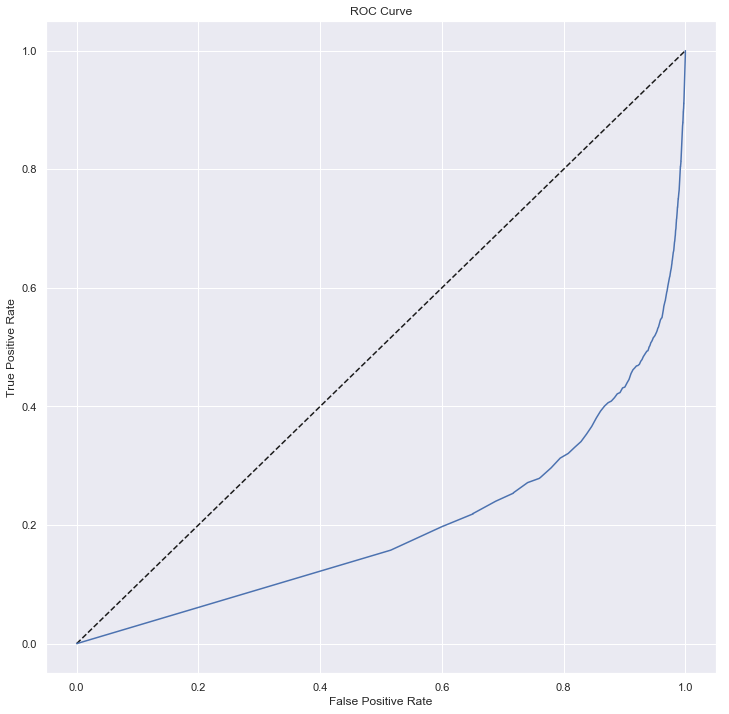

In [122]:
# ROC Curve
y_r_pred_prob = clf.predict_proba(X_test)[:,1]

auc_score = roc_auc_score(y_test, y_r_pred_prob)
print('ROC AUC Score: ' + str(auc_score))
print()

fpr, tpr, thresholds = roc_curve(y_test, y_r_pred_prob) # False Positive, True Positive, Threshold

plt.figure(figsize=(12,12))
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()


## SVM

In [81]:

# svm_test(X_train, y_train, X_test, y_test, 5000, [.5, 1.0, 1.5, 2.0, 4.0, 8.0, 10.0])

In [84]:
linSVC = svm.LinearSVC(random_state=50,  max_iter = 1000, C=4.0) # tol=1e-5,
linSVC.fit(X_train, y_train)

y_r_pred = linSVC.predict(X_test)

print_stats(y_test, y_r_pred)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Confusion Matrix:
[[135044     33]
 [  1403      0]]


Total Savings -14360


Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99    135077
           1       0.00      0.00      0.00      1403

   micro avg       0.99      0.99      0.99    136480
   macro avg       0.49      0.50      0.50    136480
weighted avg       0.98      0.99      0.98    136480


Accuracy Score: 0.9894783118405627


## Splitting Up Data Based on Customer Class

### Add description....

In [ ]:
## Splitting Up Data Based on Monthly Income

In [ ]:
## Splitting Up Data Based on Monthly Income

In [ ]:
## Splitting Up Data Based on Monthly Income

In [ ]:
## Splitting Up Data Based on Monthly Income

## ANNEX